In [2]:
run cargar_shapefile.py

In [1]:
from osgeo import gdal

In [3]:
def boundingBoxToOffsets(bbox, geot):
    col1 = int((bbox[0] - geot[0]) / geot[1])
    col2 = int((bbox[1] - geot[0]) / geot[1]) + 1
    row1 = int((bbox[3] - geot[3]) / geot[5])
    row2 = int((bbox[2] - geot[3]) / geot[5]) + 1
    return [row1, row2, col1, col2]

def geotFromOffsets(row_offset, col_offset, geot):
    new_geot = [
        geot[0] + (col_offset * geot[1]),
        geot[1], 0.0, geot[3] + (row_offset * geot[5]),
        0.0, geot[5]]
    return new_geot

In [4]:
imgtif = gdal.Open("MAPA_AEROVIAS_GEORECTIFICADO2.tif",
                   gdal.GA_ReadOnly)
imgtif.RasterCount
bands = list(map(lambda x: imgtif.GetRasterBand(x),
                 range(1, imgtif.RasterCount + 1)))
matrs = list(map(lambda x: x.ReadAsArray(), bands))

/home/dramon/anaconda3/envs/testgdal/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


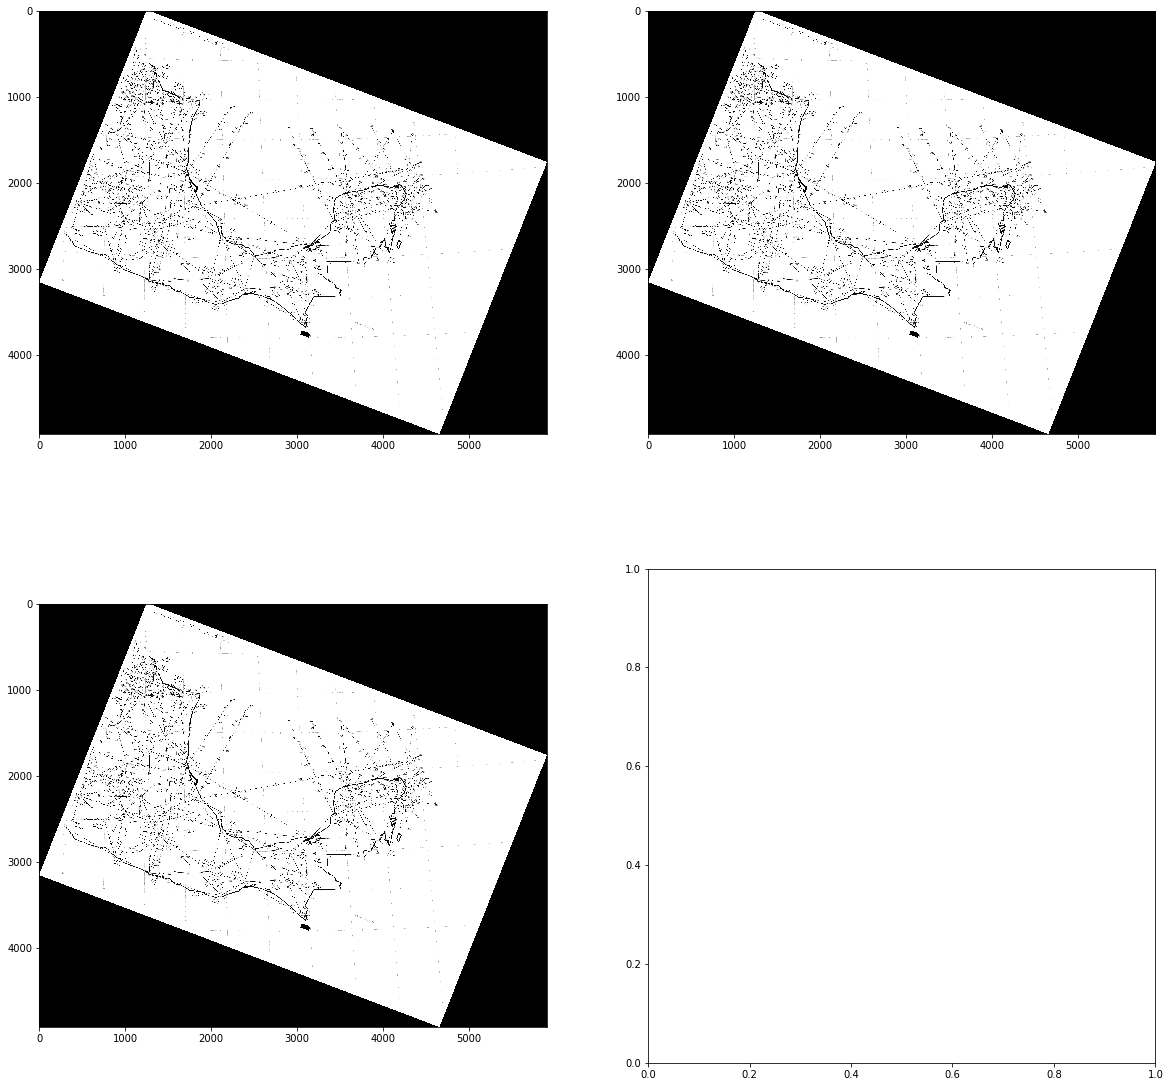

In [5]:
fig, axes = plt.subplots(2,2,figsize=(20,20))
axes = axes.reshape(-1,)
for ax, matr in zip(axes, matrs):
    ax.imshow(matr, plt.cm.Greys_r)
fig.show()

In [6]:
# get geotransform and no data for raster
geot = imgtif.GetGeoTransform()
nodata = imgtif.GetRasterBand(1).GetNoDataValue()
# empty list to hold the zonal statistics once they are calculated
zstats = []
mem_driver = ogr.GetDriverByName("Memory")
mem_driver_gdal = gdal.GetDriverByName("MEM")
shp_name = "temp"
tp_ds = mem_driver.CreateDataSource(shp_name)
tp_lyr = tp_ds.CreateLayer('polygons', None, ogr.wkbPolygon)
fn_zones = "./HYS20120420/GIS_06705_22178_08.shp"
p_ds = ogr.Open(fn_zones)
lyr = p_ds.GetLayer()
p_feat = lyr.GetNextFeature()
tp_lyr.CreateFeature(p_feat.Clone())
# get the bounding box of the polygon feature and convert the coordinates
# to cell offsets
offsets = boundingBoxToOffsets(p_feat.GetGeometryRef().GetEnvelope(),\
        geot)
# calculate the new geotransform for the polygonized raster
new_geot = geotFromOffsets(offsets[0], offsets[2], geot)
tr_ds = mem_driver_gdal.Create("",
        offsets[3] - offsets[2], \
        offsets[1] - offsets[0], \
        1, gdal.GDT_Byte)
tr_ds.SetGeoTransform(new_geot)
gdal.RasterizeLayer(tr_ds, [1], tp_lyr, burn_values=[1])
tr_array = tr_ds.ReadAsArray()
gdal.RasterizeLayer(tr_ds, [1], tp_lyr, burn_values=[1])

0

In [7]:
geot

(-105.36490815635833,
 0.004354034387426428,
 0.0,
 30.447847585714538,
 0.0,
 -0.004354034387426428)